<a href="https://colab.research.google.com/github/seunghee0518/AI_python/blob/main/EfficientNet_b4_MVtecAD_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## trina/ test 나눠서 학습

In [2]:
'''
torch.hub : Pytorch Hub는 연구 재현성을 촉진하도록 설계된 사전 훈련 된 모델 저장소
nvidia_efficientnet_b4 사전 모델 가져옴
'''
import torch
model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_efficientnet_b4', pretrained=True)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:14: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:18: UserWarning: pytorch_quantization module not found, quantization will not be available
  "pytorch_quantization module not found, quantization will not be available"


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
## 학습 코드
import warnings
warnings.filterwarnings('ignore')

from glob import glob
from tqdm import tqdm
import cv2
#import timm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, accuracy_score
import gc

import pandas as pd
import numpy as np
import json
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# from efficientnet_pytorch import EfficientNet
# model_name = 'efficientnet-b0'  # b5

# image_size = EfficientNet.get_image_size(model_name)
# print(image_size)
# model = EfficientNet.from_pretrained(model_name, num_classes=88)

In [9]:
## 데이타 로드!!
device = torch.device('cuda')
batch_size  = 32
random_seed = 1234
img_size = 224
random.seed(random_seed)
torch.manual_seed(random_seed)

## make dataset
# data_path = 'president/president_data'  # class 별 폴더로 나누어진걸 확 가져와서 라벨도 달아준다
# train_dataset = datasets.ImageFolder(data_path,
#                                      transforms.Compose([
#                                      transforms.Resize((224, 224)),
#                                      transforms.ToTensor(), # 이미지 데이터를 tensor로 바꿔준다.
#                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize는 많은 이미지의 평균, 표준편차로 정함(보통 많이 하는 값이라고함)
#                                 ]))

## 이미지 경로
#train_png = sorted(glob('/content/drive/Othercomputers/내 MacBook Pro/open/train/*.png'))
#test_png = sorted(glob('/content/drive/Othercomputers/내 MacBook Pro/open/train/*.png'))

train_imgs = np.load('/content/drive/MyDrive/DACON_이상치 탐지 알고리즘 경진대회/train_imgs_224.npy')
train_y = pd.read_csv("/content/drive/Othercomputers/내 MacBook Pro/open/train_df.csv")

train_labels = train_y["label"] # 레이블순서는 이미지 파일 순서대로임

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))} # 오름차순으로 레이블별로 숫자 부여(0부터 시작)

train_labels = [label_unique[k] for k in train_labels]

class Custom_dataset_3(Dataset):
    def __init__(self, img_paths, labels, mode='train'):
        self.img_paths = img_paths
        self.labels = labels
        self.mode=mode
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        img = self.img_paths[idx]
        img = transforms.ToTensor()(img)
        img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)

        if self.mode=='test':
            pass
        ## 레이블 > 원-핫 인코딩 하기 
        label = self.labels[idx]# (원핫인코딩 안할거면 해당 코드만 필요)
        return img, label


train_dataset = Custom_dataset_3(np.array(train_imgs), np.array(train_labels), mode='train')

### 데이터셋 분리 > 층화추출 & 테스터 데이터 비율 : 0.3, 시드 : 1234, 셔플 = True(default)
train_idx, test_idx = train_test_split(list(range(len(train_dataset))), stratify=train_labels, test_size=0.3, random_state=random_seed)

datasets = {} # 데이터셋을 담을 딕셔너리
datasets['train'] = Subset(train_dataset, train_idx)
datasets['test']  = Subset(train_dataset, test_idx)

## data loader 선언
dataloaders, batch_num = {}, {}
dataloaders['train'] = torch.utils.data.DataLoader(datasets['train'],
                                                  batch_size=batch_size, shuffle=True,
                                                  num_workers=4)
dataloaders['test']  = torch.utils.data.DataLoader(datasets['test'],
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=4)
batch_num['train'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['test'])
print('batch_size : %d,  train/test(데이터셋개수/배치사이즈) : %d / %d' % (batch_size, batch_num['train'],batch_num['test']))

batch_size : 32,  train/test(데이터셋개수/배치사이즈) : 94 / 41


In [10]:
### f1 스코어 함수 
# def score_function(real, pred): # 라이브러리 > sklearn.metrics 
#     score = f1_score(real, pred, average="macro")
#     return score
!pip install torchmetrics
from torchmetrics import F1Score # 라이브러리 > torchmetrics
f1_score = F1Score(num_classes=len(label_unique))

# target = torch.tensor([0, 1, 2, 0, 1, 2])
# preds = torch.tensor([0, 2, 1, 0, 0, 1])
#f1_score(preds, target)

In [12]:
# 참고 블로그 : https://keep-steady.tistory.com/35
import gc
# gc.collect()
# torch.cuda.empty_cache()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    #train_loss, train_acc, valid_loss, valid_acc = [], [], [], []
    train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1 = [], [], [], [], [], []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))# - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss, running_corrects, num_cnt = 0.0, 0, 0
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) # device = torch.device('cuda')
                labels = labels.to(device) # device = torch.device('cuda')

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_cnt += len(labels)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = float(running_loss / num_cnt)
            epoch_acc  = float((running_corrects.double() / num_cnt).cpu()*100)
            f1 = f1_score(labels.cpu().data, preds.cpu())

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
                train_f1.append(f1)
            else:
                valid_loss.append(epoch_loss)
                valid_acc.append(epoch_acc)
                valid_f1.append(f1)

            print('{} Loss: {:.5f} Acc: {:.5f} f1: {:.5f}'.format(phase, epoch_loss, epoch_acc, f1))
           
            # deep copy the model(최적모델 저장)
            if phase == 'test' and epoch_acc > best_acc:
                best_idx = epoch
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
#                 best_model_wts = copy.deepcopy(model.module.state_dict())
                print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
        # 한에포크 마다 실행 시간 출력하기
        time_elapsed = time.time() - since
        print('one epochs training time : {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('\n')
        # 한 에포크마다 필요없는 메모리 지우기 : 지우기 효과는 아직 확인 못해봄
        try:      
          gc.collect() # cpu 비움
          torch.cuda.empty_cache() # gpu 비움
        except:
          pass
    ## 학습 마무리 후
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'president_model.pt')
    print('model saved')
    return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1

# 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # set gpu

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model.parameters(), 
                         lr = 0.05,
                         momentum=0.9,
                         weight_decay=1e-4)

lmbda = lambda epoch: 0.98739
exp_lr_scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

# 사전학습된 가중치와 모델을 가져와 데이터셋으로 추가 모델 학습
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc, train_f1, valid_f1 = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

Epoch 0/100
----------
train Loss: 0.08464 Acc: 97.76144 f1: 1.00000
test Loss: 0.48439 Acc: 89.01869 f1: 1.00000
==> best model saved - 0 / 89.0
one epochs training time : 0m 49s
Epoch 1/100
----------
train Loss: 0.04664 Acc: 98.59673 f1: 1.00000
test Loss: 0.41441 Acc: 91.74455 f1: 1.00000
==> best model saved - 1 / 91.7
one epochs training time : 1m 38s
Epoch 2/100
----------
train Loss: 0.03930 Acc: 99.03107 f1: 1.00000
test Loss: 0.50928 Acc: 88.55140 f1: 1.00000
one epochs training time : 2m 28s
Epoch 3/100
----------
train Loss: 0.04135 Acc: 98.83060 f1: 1.00000
test Loss: 0.43042 Acc: 91.97819 f1: 1.00000
==> best model saved - 3 / 92.0
one epochs training time : 3m 17s
Epoch 4/100
----------
train Loss: 0.05250 Acc: 98.63014 f1: 1.00000
test Loss: 0.39743 Acc: 91.90031 f1: 1.00000
one epochs training time : 4m 6s
Epoch 5/100
----------
train Loss: 0.04072 Acc: 99.03107 f1: 1.00000
test Loss: 0.48282 Acc: 91.27726 f1: 1.00000
one epochs training time : 4m 56s
Epoch 6/100
-----

best model : 15 - 93 / 0.4


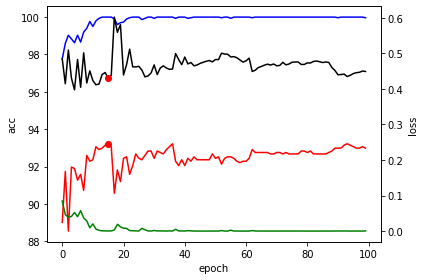

In [13]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

In [14]:
## 학습 결과 검수
def test_and_visualize_model(model, phase = 'test', num_images=4):
    # phase = 'train', 'valid', 'test'
    
    was_training = model.training
    model.eval()
    fig = plt.figure()
    
    running_loss, running_corrects, num_cnt = 0.0, 0, 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)  # batch의 평균 loss 출력

            running_loss    += loss.item() * inputs.size(0)
            running_corrects+= torch.sum(preds == labels.data)
            num_cnt += inputs.size(0)  # batch size

    #         if i == 2: break

        test_loss = running_loss / num_cnt
        test_acc  = running_corrects.double() / num_cnt       
        print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))

    # 예시 그림 plot
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)        

            # 예시 그림 plot
            for j in range(1, num_images+1):
                ax = plt.subplot(num_images//2, 2, j)
                ax.axis('off')
                ax.set_title('%s : %s -> %s'%(
                    'True' if class_names[str(labels[j].cpu().numpy())]==class_names[str(preds[j].cpu().numpy())] else 'False',
                    class_names[str(labels[j].cpu().numpy())], class_names[str(preds[j].cpu().numpy())]))
                imshow(inputs.cpu().data[j])          
            if i == 0 : break


    model.train(mode=was_training);  # 다시 train모드로
    
    ## TEST!
    test_and_visualize_model(model, phase = 'test')